# Step 3: Use Reinforcement Learning to align SAWYER to preferred responses

In [ ]:
!pip install transformers[torch] datasets trl[peft] wandb peft bitsandbytes sentence-transformers

In [ ]:
import os
import pandas as pd
import torch
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, pipeline, AutoModelForSequenceClassification, AutoModelForCausalLM, BitsAndBytesConfig
import time
import numpy as np
from scipy import stats

from tqdm.auto import tqdm
from trl import AutoModelForCausalLMWithValueHead, PPOConfig, PPOTrainer, set_seed, create_reference_model
tqdm.pandas()

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
dolly = load_dataset('databricks/databricks-dolly-15k')
dolly

Generating train split:   0%|          | 0/15011 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15011
    })
})

In [ ]:
dolly['train'][0]

{'instruction': 'When did Virgin Australia start operating?',
 'context': "Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.",
 'response': 'Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.',
 'category': 'closed_qa'}

In [ ]:
import huggingface_hub
from google.colab import userdata

huggingface_hub.login(token=userdata.get('HF_TOKEN').strip())

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
# load our custom tokenizer

username, repo_name = 'profoz', 'sawyer-llama-3'

tokenizer = AutoTokenizer.from_pretrained(f"{username}/{repo_name}")

tokenizer.padding_side, tokenizer.pad_token

tokenizer_config.json:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/335 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


('right', '<|end_of_text|>')

In [ ]:
STOP_TOKEN = '###STOP###'
HUMAN_TOKEN = '###HUMAN###'
BOT_TOKEN = '###BOT###'

EXTRA_TOKENS = {
    'stop_token': {
        'token': STOP_TOKEN,
        'replace_embedding_with': 'stop talking'
    },
    'human_token': {
        'token': HUMAN_TOKEN,
        'replace_embedding_with': 'The human said:'
    },
    'bot_token': {
        'token': BOT_TOKEN,
        'replace_embedding_with': 'The assistant said:'
    }
}

base_model = 'meta-llama/Meta-Llama-3-8B'

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False,
)

model = AutoModelForCausalLM.from_pretrained(
    base_model,
    torch_dtype=torch.bfloat16,
    quantization_config=quant_config,
    device_map={"": 0}
)

model.resize_token_embeddings(len(tokenizer))

for extra_token, extra_info in EXTRA_TOKENS.items():
    token_id = tokenizer(extra_info['token'])['input_ids'][-1]
    new_embedding = model.model.embed_tokens.weight.data[tokenizer(extra_info['replace_embedding_with'])['input_ids'][1:]].mean(dim=0, keepdim=True)
    EXTRA_TOKENS[extra_token]['new_embedding'] = new_embedding
    model.model.embed_tokens.weight.data[token_id] = EXTRA_TOKENS[extra_token]['new_embedding'].clone()
    EXTRA_TOKENS[extra_token]['token_id'] = token_id
    print(f"Replaced token \"{extra_info['token']}\" (token id {token_id}) weight with weight for \"{extra_info['replace_embedding_with']}\"")

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/126 [00:00<?, ?B/s]

Replaced token "###STOP###" (token id 128256) weight with weight for "stop talking"
Replaced token "###HUMAN###" (token id 128257) weight with weight for "The human said:"
Replaced token "###BOT###" (token id 128258) weight with weight for "The assistant said:"


In [ ]:
model.model.embed_tokens.weight.data

tensor([[ 1.3733e-03,  5.0964e-03, -3.0365e-03,  ...,  2.2888e-03,
         -1.9531e-03, -1.7166e-05],
        [-2.7313e-03,  1.9379e-03, -1.3733e-03,  ..., -5.1498e-05,
         -1.3962e-03, -1.9836e-03],
        [ 9.5367e-04, -1.3367e-02,  4.1771e-04,  ...,  2.5940e-03,
          7.0496e-03,  4.1809e-03],
        ...,
        [-1.9775e-02, -8.9722e-03,  5.1880e-03,  ...,  2.2461e-02,
          1.0803e-02,  8.2397e-03],
        [-4.0894e-03, -6.9580e-03, -5.3406e-03,  ...,  4.5166e-03,
          3.0670e-03,  3.9062e-03],
        [-4.3030e-03, -4.1199e-03, -4.0283e-03,  ..., -2.1057e-03,
         -4.9744e-03,  6.8665e-03]], device='cuda:0', dtype=torch.bfloat16)

In [ ]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM

model = PeftModel.from_pretrained(model, 'profoz/sawyer-llama-3')

model = AutoModelForCausalLMWithValueHead.from_pretrained(
    model,
    torch_dtype=torch.bfloat16,
    is_trainable=True
)

adapter_config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/2.32G [00:00<?, ?B/s]

In [ ]:
def join_convo(conversation):
    convo = ''''''
    last_speaker = None
    for speaker, message in conversation:
        last_speaker = speaker
        if speaker == 'human':
            convo += f"{EXTRA_TOKENS['human_token']['token']} {message} "
        elif speaker == 'assistant':
            convo += f"{EXTRA_TOKENS['bot_token']['token']} {message} "
    if last_speaker == 'human':
        return convo.strip() + f" {EXTRA_TOKENS['bot_token']['token']}"
    return convo.strip() + f" {EXTRA_TOKENS['stop_token']['token']}"

join_convo(
    [
        ('human', 'hi'),
        ('assistant', 'sup')
    ]
)

'###HUMAN### hi ###BOT### sup ###STOP###'

In [ ]:
join_convo(
    [
        ('human', 'hi')
    ]
)

'###HUMAN### hi ###BOT###'

In [ ]:
# quick cleaning function to clean some text
def ascci(text): return ''.join(char if ord(char) < 128 else '?' for char in text)

def preprocess_function(examples):
    new_examples = {
        "input_ids": [],
        "attention_mask": [],
        "input_text": [],
        "formatted_convo": []
    }
    for instruction, context in zip(examples["instruction"], examples['context']):
        if context:
            instruction = f'{instruction}\n\n{context}'

        input_text = join_convo([['human', instruction]])

        tokenized_question = tokenizer(input_text, return_tensors='pt')
        new_examples['input_text'].append(input_text)
        new_examples["input_ids"].append(tokenized_question["input_ids"])
        new_examples["attention_mask"].append(tokenized_question["attention_mask"])
        new_examples['formatted_convo'].append(input_text)
    return new_examples

dolly = dolly.map(preprocess_function, batched=True, batch_size=64)

Parameter 'function'=<function preprocess_function at 0x7e2a2304da20> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/15011 [00:00<?, ? examples/s]

In [ ]:
dolly.set_format(type="torch")

<Axes: >

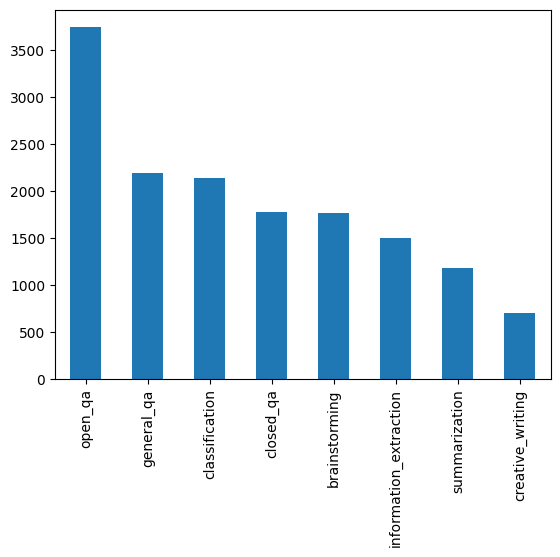

In [ ]:
pd.Series(dolly['train']['category']).value_counts().plot(kind='bar')

In [ ]:
# dolly = dolly.filter(lambda x: 'qa' in x['category'])

In [ ]:
dolly = dolly['train'].filter(
    lambda x: x["input_ids"].shape[-1] < 128, batched=False).shuffle(seed=42).select(range(2_000))

Filter:   0%|          | 0/15011 [00:00<?, ? examples/s]

<Axes: >

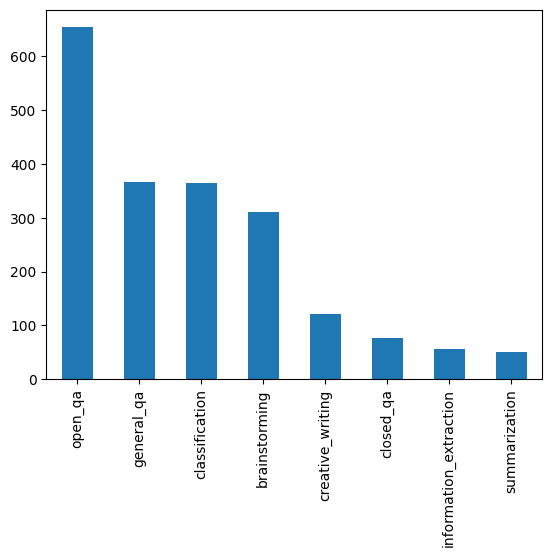

In [ ]:
pd.Series(dolly['category']).value_counts().plot(kind='bar')

In [ ]:
dolly = dolly.train_test_split(test_size=0.1, seed=42)

dolly

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'input_ids', 'attention_mask', 'input_text', 'formatted_convo'],
        num_rows: 1800
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'input_ids', 'attention_mask', 'input_text', 'formatted_convo'],
        num_rows: 200
    })
})

In [ ]:
dolly['train'][0]

{'instruction': 'Why did the earliest vendors and retailers in the U.S. decide to charge 99 cents rather than a dollar?',
 'context': '',
 'response': 'Because the cashier would have to make change in the cash register for 99 cents, forcing a record of the sale, whereas if the vendor/retailer charged $1, the cashier could pocket the dollar without a record of the transaction.',
 'category': 'open_qa',
 'input_ids': tensor([[128257,   8595,   1550,    279,  30758,  29629,    323,  30282,    304,
             279,    549,    815,     13,  10491,    311,   6900,    220,   1484,
           31291,   4856,   1109,    264,  18160,     30,    220, 128258]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1]]),
 'input_text': '###HUMAN### Why did the earliest vendors and retailers in the U.S. decide to charge 99 cents rather than a dollar? ###BOT###',
 'formatted_convo': '###HUMAN### Why did the earliest vendors and retailers in 

In [ ]:
generation_kwargs = {
    "do_sample": True,
    "eos_token_id": EXTRA_TOKENS['stop_token']['token_id'],
    'pad_token_id': EXTRA_TOKENS['stop_token']['token_id']
}

output = model.generate(
    **tokenizer(
        dolly['train'][0]['formatted_convo'],
        return_tensors='pt', max_length=128, truncation=True
        ).to(0),
    **generation_kwargs,
    max_new_tokens=32
)
tokenizer.decode(output[0])


'###HUMAN### Why did the earliest vendors and retailers in the U.S. decide to charge 99 cents rather than a dollar? ###BOT### While the exact reasons are unknown, some speculate the $0.99 may have been chosen as a way to set prices lower than competitors to increase sales. Another'

In [ ]:
model.v_head.summary.weight

Parameter containing:
tensor([[ 0.0011, -0.0118, -0.0147,  ...,  0.0131,  0.0011, -0.0015]],
       device='cuda:0', requires_grad=True)

In [ ]:
def print_trainable_parameters(model, verbose=False):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            if verbose:
                print(f'{_} is trainable with {param.numel()} params')
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(model, verbose=True)

v_head.summary.weight is trainable with 4096 params
v_head.summary.bias is trainable with 1 params
trainable params: 4097 || all params: 4595154945 || trainable%: 8.915912627620873e-05


In [ ]:
list(filter(lambda x: 'enable' in x, dir(model.pretrained_model)))

['_enable_peft_forward_hooks']

In [ ]:
for name, param in model.named_parameters():
    if 'lora' in name and not param.requires_grad:
        print(f'Turning ON: {name}')
        param.requires_grad = True
    elif 'original_module' in name and param.requires_grad:
        print(f'Turning OFF: {name}')
        param.requires_grad = False

Turning ON: pretrained_model.base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight
Turning ON: pretrained_model.base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight
Turning ON: pretrained_model.base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight
Turning ON: pretrained_model.base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight
Turning ON: pretrained_model.base_model.model.model.layers.1.self_attn.q_proj.lora_A.default.weight
Turning ON: pretrained_model.base_model.model.model.layers.1.self_attn.q_proj.lora_B.default.weight
Turning ON: pretrained_model.base_model.model.model.layers.1.self_attn.v_proj.lora_A.default.weight
Turning ON: pretrained_model.base_model.model.model.layers.1.self_attn.v_proj.lora_B.default.weight
Turning ON: pretrained_model.base_model.model.model.layers.2.self_attn.q_proj.lora_A.default.weight
Turning ON: pretrained_model.base_model.model.model.layers.2.self_attn.q_proj.lora_B.default.weight


In [ ]:
import wandb

def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

# Set up Weights and Biases integration
# wandb.init(project="odsc-sawyer-rlhf")

In [ ]:
dolly['train'][0]['input_ids'], tokenizer.batch_decode(dolly['train'][0]['input_ids'])

(tensor([[128257,   8595,   1550,    279,  30758,  29629,    323,  30282,    304,
             279,    549,    815,     13,  10491,    311,   6900,    220,   1484,
           31291,   4856,   1109,    264,  18160,     30,    220, 128258]]),
 ['###HUMAN### Why did the earliest vendors and retailers in the U.S. decide to charge 99 cents rather than a dollar? ###BOT###'])

In [ ]:
tokenizer.batch_decode(model.generate(
    **tokenizer(
        dolly['train'][0]['formatted_convo'],
        return_tensors='pt',
    ).to(0),
    eos_token_id=EXTRA_TOKENS['stop_token']['token_id'],
    max_new_tokens=128,
    min_new_tokens=2,
    top_k=0.0,
    top_p=1.0,
    ))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:427: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128256 for open-end generation.


['###HUMAN### Why did the earliest vendors and retailers in the U.S. decide to charge 99 cents rather than a dollar? ###BOT### The reason for this is that the price of 99 cents is more appealing to customers than the price of a dollar. It is a psychological trick that makes the product seem cheaper than it actually is. ###STOP###']

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

roberta_tokenizer = AutoTokenizer.from_pretrained("textattack/roberta-base-CoLA")
roberta_model = AutoModelForSequenceClassification.from_pretrained("textattack/roberta-base-CoLA")

cola_pipeline = pipeline('text-classification', model=roberta_model, tokenizer=roberta_tokenizer)

def get_cola_scores(texts):
    scores = []
    # note function_to_apply='none' gives me logits which can be negative (what we want)
    results = cola_pipeline(texts, function_to_apply='none', top_k=None)
    for result in results:
        for label in result:
            if label['label'] == 'LABEL_1':  # good grammar:
                scores.append(label['score'])
    return scores


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at textattack/roberta-base-CoLA were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from sentence_transformers import SentenceTransformer, util

sim_model = SentenceTransformer("nq-distilbert-base-v1")

def get_similarity_scores(queries, responses):
    """
    Calculate similarity scores for each pair of sentences from queries and responses.

    Args:
        queries (list): List of query sentences.
        responses (list): List of response sentences.

    Returns:
        list: List containing similarity scores for each pair.
    """

    # Encode the queries and responses
    query_embeddings = sim_model.encode(queries)
    response_embeddings = sim_model.encode(responses)

    # Calculate similarity scores for each pair
    scores = []
    for q_embed, r_embed in zip(query_embeddings, response_embeddings):
        similarity = util.cos_sim(q_embed, r_embed)
        scores.append(similarity.item())

    return scores

print(get_similarity_scores(['how do you greet someone?', 'how do you greet someone?'], ['tell them hello', 'tell them bye']))

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/540 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/554 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[0.4387131631374359, 0.14182493090629578]


In [ ]:
reward_model_name = 'profoz/sawyer-llama-reward' # From our rewards notebook

reward_pipe = pipeline("text-classification", model=reward_model_name)

def get_reward_scores(queries, responses):
    scores = []
    inputs = [{'text': q, 'text_pair': r} for q, r in zip(queries, responses)]
    responses = reward_pipe(
        inputs,
        function_to_apply='none',
        truncation=True,
        max_length=511
    )
    return [_['score'] for _ in responses]


config.json:   0%|          | 0.00/764 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [ ]:
print(get_cola_scores(['test', 'hi']))
print(get_reward_scores(['test', 'hi'], ['test', 'hi']))
print(get_similarity_scores(['test', 'hi'], ['test', 'hi']))

[1.4301540851593018, -0.219132661819458]
[-6.883139610290527, -6.443085670471191]
[1.0, 0.9999998807907104]


In [ ]:
generation_kwargs

{'do_sample': True, 'eos_token_id': 128256, 'pad_token_id': 128256}

In [ ]:
print(get_reward_scores(['test', 'hi'], ['test', 'hi']))


[-6.883139610290527, -6.443085670471191]


In [ ]:
ref_model = create_reference_model(model)

In [ ]:
ppo_config = PPOConfig(
    model_name='sawyer_rl',
    learning_rate=1.41e-5,
    batch_size=8,
    gradient_accumulation_steps=4,
    ppo_epochs=2,
    seed=42,
    log_with="wandb",
    optimize_cuda_cache=True,
    early_stopping=True
)

ppo_trainer = PPOTrainer(
    ppo_config,
    model,
    ref_model=ref_model,
    tokenizer=tokenizer,
    dataset=dolly['train'],
    data_collator=collator,
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
def make_test_scores(model):
    test_scores = {'reward': [], 'cola': [], 'responses': [], 'queries': [], 'similarity': []}
    for input_ids in tqdm(dolly['test']['input_ids']):
        response = model.generate(
            input_ids=input_ids.to(device), **generation_kwargs,
            max_new_tokens=256
        )
        response = tokenizer.decode(response[0])
        try:
            cleaned_query = response.split(EXTRA_TOKENS['bot_token']['token'])[0].split(EXTRA_TOKENS['human_token']['token'])[1]
            cleaned_response = response.split(EXTRA_TOKENS['bot_token']['token'])[1].split(EXTRA_TOKENS['stop_token']['token'])[0]

            r = get_reward_scores(
                queries=[cleaned_query],
                responses=[cleaned_response]
            )
            c = get_cola_scores(
                [cleaned_response]
            )
            s = get_similarity_scores(
                queries=[cleaned_query],
                responses=[cleaned_response]
            )

            test_scores['reward'] += r
            test_scores['cola'] +=  c
            test_scores['similarity'] += s

            test_scores['responses'].append(cleaned_response)
            test_scores['queries'].append(cleaned_query)


        except Exception as e:
            print(f'response: {response}. Error: {e}')

    return test_scores


In [ ]:
dolly['test'][4]

{'instruction': 'What is the difference between solar power and hydrogen fuel cell?  What are the advantages of hydrogen?',
 'context': '',
 'response': 'Solar captures the harvesting of the sun while hydrogen is the osmosis process of extracting the hydrogen cells to create energy.  Hydrogen allows for a more consistent energy source while also enabling higher load generation over solar.',
 'category': 'general_qa',
 'input_ids': tensor([[128257,   3639,    374,    279,   6811,   1990,  13238,   2410,    323,
           35784,  10633,   2849,     30,    220,   3639,    527,    279,  22934,
             315,  35784,     30,    220, 128258]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'input_text': '###HUMAN### What is the difference between solar power and hydrogen fuel cell?  What are the advantages of hydrogen? ###BOT###',
 'formatted_convo': '###HUMAN### What is the difference between solar power and hydrogen fuel cell?  Wha

In [ ]:
old_scores = make_test_scores(model)
print(pd.DataFrame(old_scores).describe())

pd.DataFrame(old_scores).head(10)

  0%|          | 0/200 [00:00<?, ?it/s]

           reward        cola  similarity
count  200.000000  200.000000  200.000000
mean     5.702665    1.142447    0.601367
std      3.518846    0.485328    0.229995
min     -6.876436   -0.726761    0.022396
25%      5.586220    0.923370    0.474002
50%      7.444443    1.250957    0.656341
75%      7.783892    1.481098    0.792025
max      7.938239    1.993711    0.961914


,reward,cola,responses,queries,similarity
0,7.111549,0.909536,VCF (Variant Call Format) is a file format us...,What is VCF?,0.446424
1,7.837705,0.586284,"When doing meal prep efficiently, there are s...",How do you do meal prep efficiently and make ...,0.814939
2,6.141927,-0.112614,"Colorado, Washington.",Tell me which of these States' shapes have ex...,0.208697
3,7.865098,1.149171,"Yes, many RVs have bathrooms and some types o...",Do RVs have bathrooms?,0.830622
4,7.778332,1.425297,Solar power is a renewable energy that conver...,What is the difference between solar power an...,0.814308
5,7.921837,1.412548,Southern France and Spain are excellent place...,What is the best location for a family vacati...,0.725205
6,7.908982,1.335448,Rapid economic growth in Libya prior to 1990 ...,What enabled Libya to obtain rapid economic g...,0.700436
7,4.091623,0.700383,"Sure, I can help you plan a first date in San...",Help plan a first date in San Francisco,0.528415
8,7.572845,1.339877,"According to Wikipedia, the Summer Breeze Ope...",How many people attended the Summer Breeze Op...,0.547274
9,6.162791,0.980713,"Tortola, Virgin Gorda, Anegada, and Jost van ...",What are the four largest British Virgin Isla...,0.168026


In [ ]:
torch.cuda.empty_cache()

In [ ]:
class LengthSampler:
    def __init__(self, min_value, max_value):
        self.values = list(range(min_value, max_value))
    def __call__(self):
        return int(np.random.choice(self.values))

max_output_size = LengthSampler(128, 256)
min_output_size = LengthSampler(2, 8)

max_output_size(), min_output_size()

(227, 4)

In [ ]:
def combine_reward_and_sim(r, s):
    if s < 0 and r < 0:
        return -(r * s)
    else:
        return r * s

In [ ]:
# Future work: replace with another LLM supervising, maybe even sawyer itself to use as red teaming?

In [ ]:
EXTRA_TOKENS['stop_token']['token']

'###STOP###'

In [ ]:
steps = 0
rlhf_repo_name = 'sawyer-llama-3-rlf'
QUERY_KEY = EXTRA_TOKENS['human_token']['token']
RESPONSE_KEY = EXTRA_TOKENS['bot_token']['token']

for epoch in tqdm(range(ppo_config.ppo_epochs)):
    ppo_trainer.dataset = ppo_trainer.dataset.shuffle() # shuffle every epoch!
    for batch in tqdm(ppo_trainer.dataloader):
        batch['response'] = []
        batch['query'] = []
        batch['rewards'] = []
        response_tensors = []
        for input_ids in batch["input_ids"]:
            generation_kwargs.update({'max_new_tokens': max_output_size()})
            generation_kwargs.update({'min_new_tokens': min_output_size()})
            batch['query'].append(
                tokenizer.batch_decode(input_ids, skip_special_tokens=False)[0].split(QUERY_KEY)[1].split(RESPONSE_KEY)[0].strip())
            response_tensor = ppo_trainer.generate(
                input_ids.squeeze(), return_prompt=False, **generation_kwargs,
            )
            batch['response'].append(tokenizer.batch_decode(response_tensor, skip_special_tokens=True)[0].replace(EXTRA_TOKENS['stop_token']['token'], ''))
            response_tensors.append(response_tensor.squeeze())
        # Run PPO step
        try:
            batch['reward_score'] = get_reward_scores(batch['query'], batch['response'])
            # ONLY USING our reward mechanism here

            # uncomment this and the line below to use all three
            # batch['cola_score'] = get_cola_scores(batch['response'])
            # batch['similarity_score'] = get_similarity_scores(batch['query'], batch['response'])
        except Exception as e:
            print('Skipping batch', e)
            print(batch)
            continue

        batch['rewards'] = [torch.tensor(r) for r in batch['reward_score']]
        # batch['rewards'] = [torch.tensor(combine_reward_and_sim(r, s) + 0.5 * c) for r, c, s in zip(batch['reward_score'], batch['cola_score'], batch['similarity_score'])]

        stats = ppo_trainer.step([_.squeeze() for _ in batch["input_ids"]], response_tensors, batch['rewards'])
        ppo_trainer.log_stats(stats, batch, batch['rewards'])

        steps += 1

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

In [ ]:
del generation_kwargs['min_new_tokens']
del generation_kwargs['max_new_tokens']
new_scores = make_test_scores(model)
pd.DataFrame(new_scores).describe()

  0%|          | 0/200 [00:00<?, ?it/s]

,reward,cola,similarity
count,200.000000,200.000000,200.000000
mean,6.924859,1.049760,0.587935
std,1.858197,0.556134,0.168621
min,-4.915857,-1.188369,0.158449
25%,7.059830,0.771734,0.470924
50%,7.597068,1.141797,0.598698
75%,7.799540,1.462207,0.718332
max,7.922405,1.918363,0.921735


In [ ]:
pd.DataFrame(old_scores).describe()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming old_scores and new_scores are defined
# Convert the score lists to DataFrames
old_scores_df = pd.DataFrame(old_scores, columns=['reward'])
new_scores_df = pd.DataFrame(new_scores, columns=['reward'])

# Get descriptive statistics
old_score_desc = old_scores_df.describe()
new_score_desc = new_scores_df.describe()

# Statistics to plot
stats = ['mean', '50%', 'min', 'max', 'std']
labels = ['Mean', 'Median', 'Min', 'Max', 'Std']

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Bar plot for statistics comparison
indices = np.arange(len(stats))  # the label locations
width = 0.35  # the width of the bars

old_values = [old_score_desc.loc[stat, 'reward'] for stat in stats]
new_values = [new_score_desc.loc[stat, 'reward'] for stat in stats]

axes[0].bar(indices - width/2, old_values, width, label='Old')
axes[0].bar(indices + width/2, new_values, width, label='New')

axes[0].set_title('Statistics Comparison')
axes[0].set_xticks(indices)
axes[0].set_xticklabels(labels)
axes[0].set_ylabel('Scores')
axes[0].legend()

# Box plot for distribution comparison
combined_scores = pd.concat([old_scores_df.assign(Score_Type='Old'), new_scores_df.assign(Score_Type='New')])
axes[1].boxplot([combined_scores[combined_scores['Score_Type']=='Old']['reward'], combined_scores[combined_scores['Score_Type']=='New']['reward']], labels=['Old', 'New'])
axes[1].set_title('Score Distribution Comparison')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from scipy import stats

# Convert the scores to numpy arrays
pre_train_predictions = np.array(old_scores['reward'])
post_train_predictions = np.array(new_scores['reward'])

# Test for normality
shapiro_pre = stats.shapiro(pre_train_predictions)
shapiro_post = stats.shapiro(post_train_predictions)

print(f"Shapiro-Wilk test for pre-training predictions: statistic={shapiro_pre[0]}, p-value={shapiro_pre[1]}")
print(f"Shapiro-Wilk test for post-training predictions: statistic={shapiro_post[0]}, p-value={shapiro_post[1]}")

# If the p-value is less than 0.05, we reject the null hypothesis and conclude that the data is not normally distributed.
if shapiro_pre[1] < 0.05 or shapiro_post[1] < 0.05:
    print("At least one of the datasets is not normally distributed. Proceeding with a non-parametric test.")

    # Run Mann-Whitney U test for unpaired data
    mwu_stat, mwu_p = stats.mannwhitneyu(pre_train_predictions, post_train_predictions)
    print(f"Mann-Whitney U test: statistic={mwu_stat}, p-value={mwu_p}\n----")

    # Run Wilcoxon signed-rank test for paired data (if applicable)
    # If the data is paired, replace the above test with the following:
    wilcoxon_stat, wilcoxon_p = stats.wilcoxon(pre_train_predictions, post_train_predictions)
    print(f"Wilcoxon signed-rank test: statistic={wilcoxon_stat}, p-value={wilcoxon_p}\n----")

    # If the p-value is less than 0.05, we reject the null hypothesis and conclude that the data is significantly different.
    if mwu_p < 0.05 or wilcoxon_p < 0.05 and (pd.DataFrame(new_scores).describe()['reward']['mean'] > pd.DataFrame(old_scores).describe()['reward']['mean']):
        print("The data is significantly different\n----")
        model.push_to_hub(f"{username}/{rlhf_repo_name}")
        tokenizer.push_to_hub(f"{username}/{rlhf_repo_name}")
        print("Model and tokenizer pushed to hub")
    else:
        print("The data is not significantly different.")
else:
    print("Both datasets are normally distributed. You may consider using a parametric test like the independent t-test.")


Shapiro-Wilk test for pre-training predictions: statistic=0.6589620113372803, p-value=7.759584870964471e-20
Shapiro-Wilk test for post-training predictions: statistic=0.5343424081802368, p-value=8.553391603370727e-23
At least one of the datasets is not normally distributed. Proceeding with a non-parametric test.
Mann-Whitney U test: statistic=16898.0, p-value=0.007304649832296909
----
Wilcoxon signed-rank test: statistic=6572.0, p-value=2.198133736688368e-05
----
The data is significantly different
----


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:168: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/2.32G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Model and tokenizer pushed to hub


In [ ]:
model.push_to_hub(f"{username}/{rlhf_repo_name}")
tokenizer.push_to_hub(f"{username}/{rlhf_repo_name}")

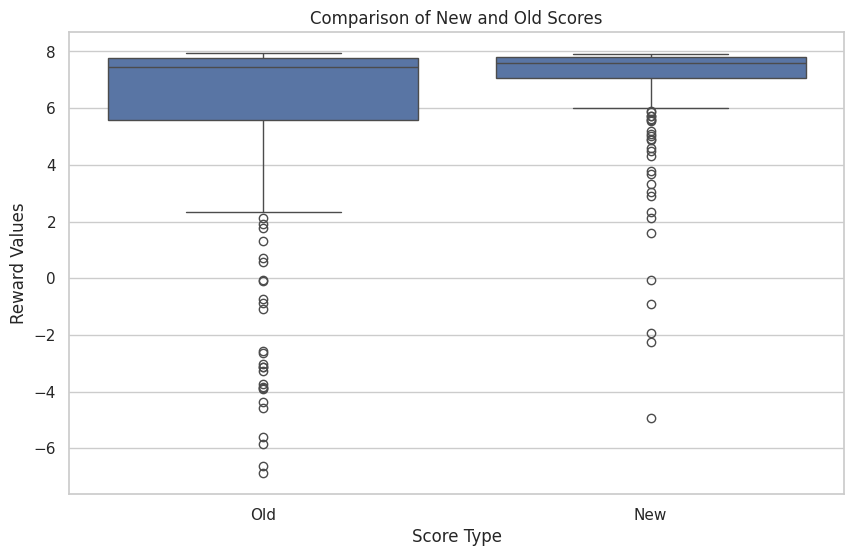

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have two DataFrames: new_scores_df and old_scores_df
# Add a 'Type' column to each DataFrame to label the data
new_scores_df['Type'] = 'New'
old_scores_df['Type'] = 'Old'

# Concatenate the two DataFrames
combined_data = pd.concat([old_scores_df[['reward', 'Type']], new_scores_df[['reward', 'Type']], ])

# Create the boxplot
sns.set(style='whitegrid')  # Set the style
plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size
sns.boxplot(x='Type', y='reward', data=combined_data)
plt.title('Comparison of New and Old Scores')
plt.ylabel('Reward Values')
plt.xlabel('Score Type')
plt.show()
